####The stock market is a place where people buy and sell shares of companies. It's like a marketplace where investors can trade stocks and other types of investments. There are rules and regulations in place to ensure fair and orderly transactions. Different stock markets exist in different countries or regions, allowing people to trade stocks and other securities.

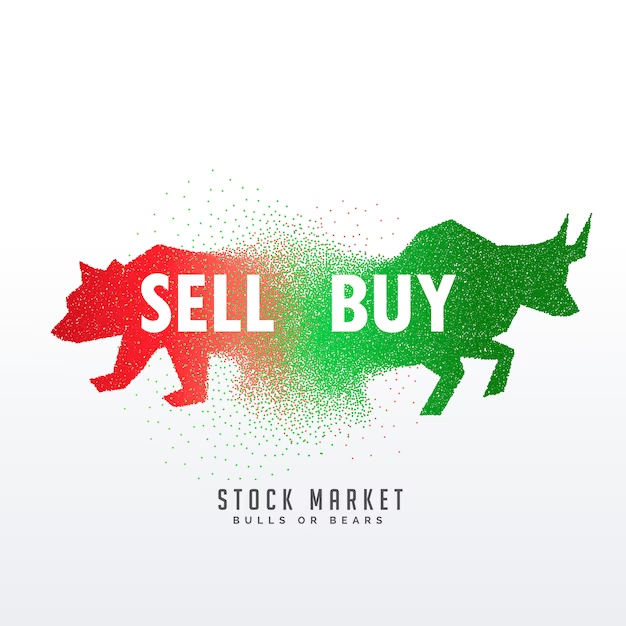

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("/content/NFLX.csv") #reading the dataset
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


####To better understand the problem at hand, let's establish our objective. Stock market analysis can be broadly divided into two categories: Fundamental Analysis and Technical Analysis.

####1. Fundamental Analysis: This involves assessing a company's potential profitability by analyzing its current business environment and financial performance.

####2. Technical Analysis: This involves studying charts and using statistical data to identify patterns and trends in the stock market.

####For this article, our focus will be on technical analysis. We will be using a dataset containing Netflix stock prices from February 2018 to Februrary 2022 to develop a model that can predict future stock prices. Let's get started!

####Here are the key points to understand:

####Dataset Variables: The dataset includes several variables such as Date, Open, High, Low, Close, Adj Close and volume.

####1. Open and Close represent the starting and final prices of the stock for a given day.
####2. High and Low indicate the maximum and minimum prices of the stock during the day.
####3. Volume represents the number of shares traded on that day.

####Weekend and Holiday Considerations: The stock market is closed on weekends and public holidays. In the dataset, certain date values are missing, such as 10/2/2018, 11/2/2018, and 24/2/2018.

####1. 11/2/2018 and 24/2/2018 are missing because they fall on the weekend.

####2. Target Variable: The calculation of profit or loss is typically based on the closing price of a stock for the day. Therefore, in this analysis, we will consider the Adj Close price as the target variable.


##By keeping these points in mind, we can proceed with our analysis.

In [3]:
df = df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1) #extracting the adj_close column
df

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001
...,...,...
1004,2022-01-31,427.140015
1005,2022-02-01,457.130005
1006,2022-02-02,429.480011
1007,2022-02-03,405.600006


In [4]:
df = df.groupby('Date')['Adj Close'].sum().reset_index()
# Group the DataFrame by 'Date' column, calculate the sum of 'Adj Close' values for each date,
# and reset the index to obtain a new DataFrame with 'Date' and 'Adj Close' columns.

In [5]:
df.Date = pd.to_datetime(df.Date)  # Convert the 'Date' column to datetime format
df.head()

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001


In [6]:
df.set_index(['Date'], inplace=True)  # Set 'Date' as the index of the DataFrame
df.head()

,Adj Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001



###Plotting the Target Variable: To understand the behavior of the target variable in our data, we can create a plot representing the closing prices over time.

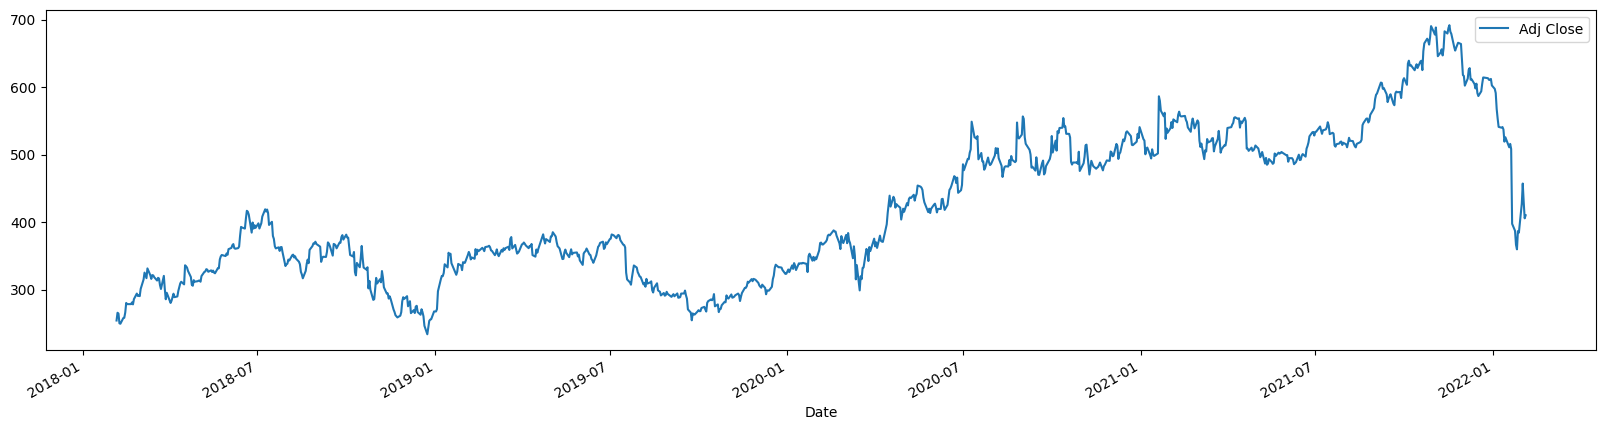

In [7]:
df.plot(figsize=(20,5))
plt.show()

In [8]:
#f- format while print statement is used

from statsmodels.tsa.stattools import adfuller

#ADF Test - if the p-value < 0.05 - Data is stationary
result = adfuller(df)

print(f'ADF Statistic,{result[0]}') #some default value based upon the critial values
print(f'p-value={result[1]}')
print(f'n_lags,{result[2]}') #previous no.of observations used for prediction

#print(f'Result: The series is {"not " if result[1]>0.05 else ""}stationary')

if(result[1]>0.05):
    print("The series is not stationary")
else:
    print("series is stationary")

ADF Statistic,-1.8125906878289955
p-value=0.3742289256820759
n_lags,6
The series is not stationary


In [9]:
diff1 = df - df.shift(1)  # Calculate the difference between consecutive rows
diff1 = diff1.dropna()  # Remove the first row with NaN values
#removing seasonality/trend

In [10]:
#f- format while print statement is used

from statsmodels.tsa.stattools import adfuller

#ADF Test - if the p-value < 0.05 - Data is stationary
result = adfuller(diff1)

print(f'ADF Statistic,{result[0]}') #some default value based upon the critial values
print(f'p-value={result[1]}')
print(f'n_lags,{result[2]}') #previous no.of observations used for prediction

#print(f'Result: The series is {"not " if result[1]>0.05 else ""}stationary')

if(result[1]>0.05):
    print("The series is not stationary")
else:
    print("series is stationary")

ADF Statistic,-14.24227599292912
p-value=1.5304022754298515e-26
n_lags,5
series is stationary


<Axes: xlabel='Date'>

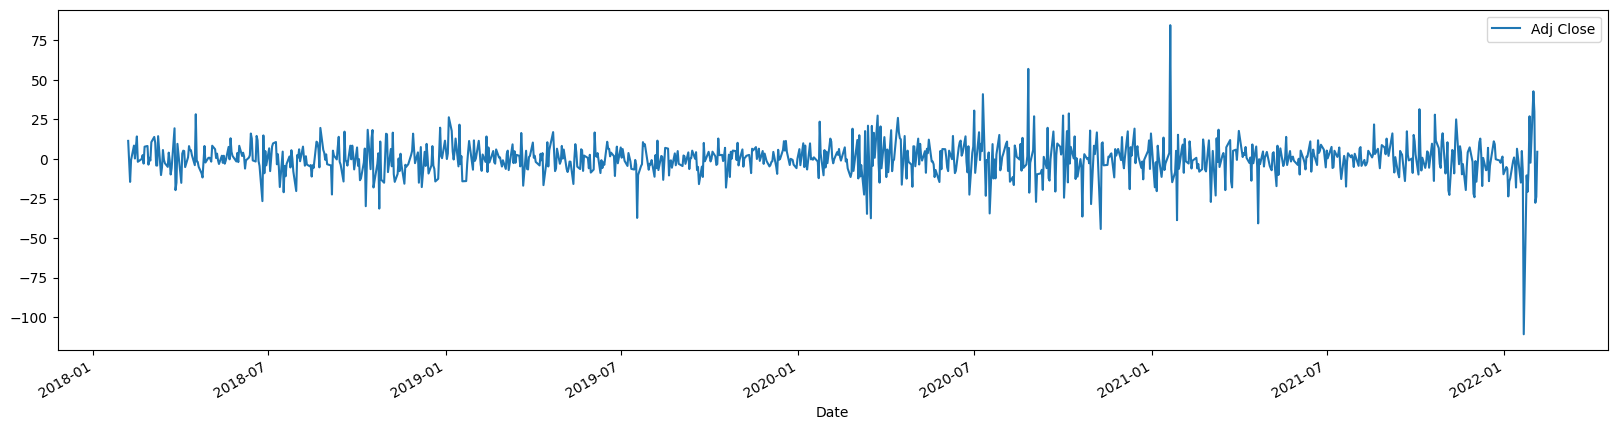

In [11]:
diff1.plot(figsize=(20,5)) #Stationary Data

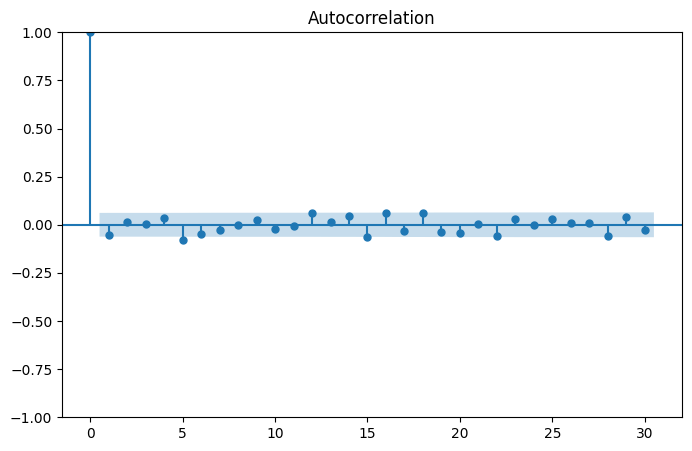

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 5))
# Plot the autocorrelation function (ACF)
plot_acf(diff1['Adj Close'], ax=ax, lags=30)
# Display the plot
plt.show()

In [13]:
#Number of lags for MA -> 6.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


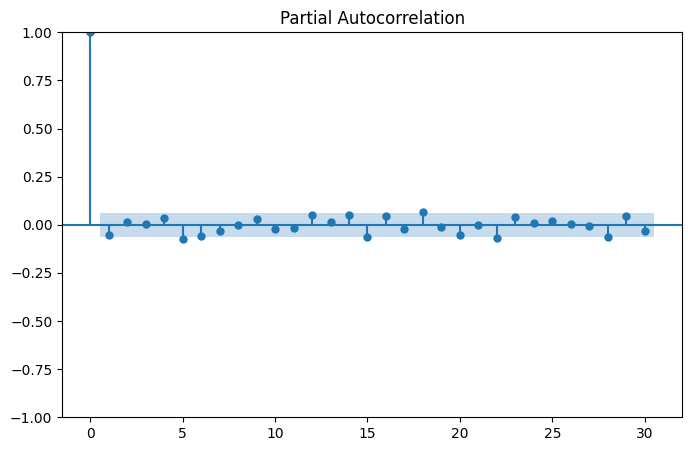

In [14]:
# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 5))
# Plot the autocorrelation function (ACF)
plot_pacf(diff1['Adj Close'], ax=ax, lags=30)
# Display the plot
plt.show()

In [15]:
#Number of lags for AR -> 6.

In [16]:
from tqdm import tqdm # to show the progress bars

def optimize_sarima(endog, order_list):
    """
    Return a dataframe with parameters and corresponding AIC values for SARIMA models.

    endog : array-like
        The observed variable.

    order_list : list
        List of (p, d, q) tuples specifying the SARIMA orders to be evaluated.

    Returns
    -------
    result_df : pandas.DataFrame
        DataFrame with SARIMA model parameters and corresponding AIC values sorted in ascending order.

    """

    results = []

    for order in tqdm(order_list, desc="Fitting SARIMA models"):
        try:
            # Fit the SARIMA model with the given order
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            # If the model fails to fit, continue to the next order combination
            continue

        # Calculate the AIC (Akaike Information Criterion)
        aic = model.aic
        results.append([order, aic])

    # Create a DataFrame with the results
    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC'])

    # Sort the DataFrame in ascending order based on AIC values
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [17]:
from itertools import product

# Define the ranges for p, d, and q
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

# Generate the SARIMA order combinations
for each in parameters_list:
    # Convert the combination to a list
    each = list(each)
    # Insert the value of 'd' at index 1
    each.insert(1, d)
    # Convert the list back to a tuple
    each = tuple(each)
    # Append the order combination to the list
    order_list.append(each)

# Print the first 10 order combinations
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [18]:
result_df = optimize_sarima(df['Adj Close'], order_list)
result_df

Fitting SARIMA models:   0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

,"(p, d, q)",AIC
0,"(6, 1, 6)",7702.722774
1,"(5, 1, 5)",7702.787210
2,"(3, 1, 3)",7702.832772
3,"(3, 1, 2)",7702.970211
4,"(5, 1, 6)",7703.398883
...,...,...
59,"(6, 1, 4)",7711.087985
60,"(1, 1, 4)",7711.092966
61,"(4, 1, 2)",7711.215033
62,"(4, 1, 6)",7711.584312


In [19]:
from statsmodels.tsa.arima.model import ARIMA
# Create ARIMA model with best order
model = ARIMA(df['Adj Close'], order=(6, 1, 6))
# building the model
result = model.fit()
# Printing the summary of the model
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1009
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3838.361
Date:                Wed, 19 Jul 2023   AIC                           7702.723
Time:                        13:43:39   BIC                           7766.627
Sample:                             0   HQIC                          7727.002
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.065      3.445      0.001       0.096       0.349
ar.L2          0.6265      0.062     10.131      0.000       0.505       0.748
ar.L3         -1.1327      0.069    -16.518      0.000      -1.267      -0.998
ar.L4          0.5390      0.062      8.658      0.000       0.417       0.661
ar.L5          0.2455      0.056      4.348      0.000       0.135       0.356
ar.L6         -0.8749      0.065    -13.535      0.000      -1.002      -0.748
ma.L1         -0.2625      0.074     -3.540      0.000      -0.408      -0.117
ma.L2         -0.5879      0.068     -8.668      0.000      -0.721      -0.455
ma.L3          1.1596      0.071     16.444      0.000       1.021       1.298
ma.L4         -0.5766      0.065     -8.882      0.000      -0.704      -0.449
ma.L5         -0.2654      0.065     -4.060      0.000      -0.394      -0.137
ma.L6          0.8397      0.073     11.528      0.000       0.697       0.982
sigma2       120.4552      2.382     50.562      0.000     115.786     125.125
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              9330.40
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

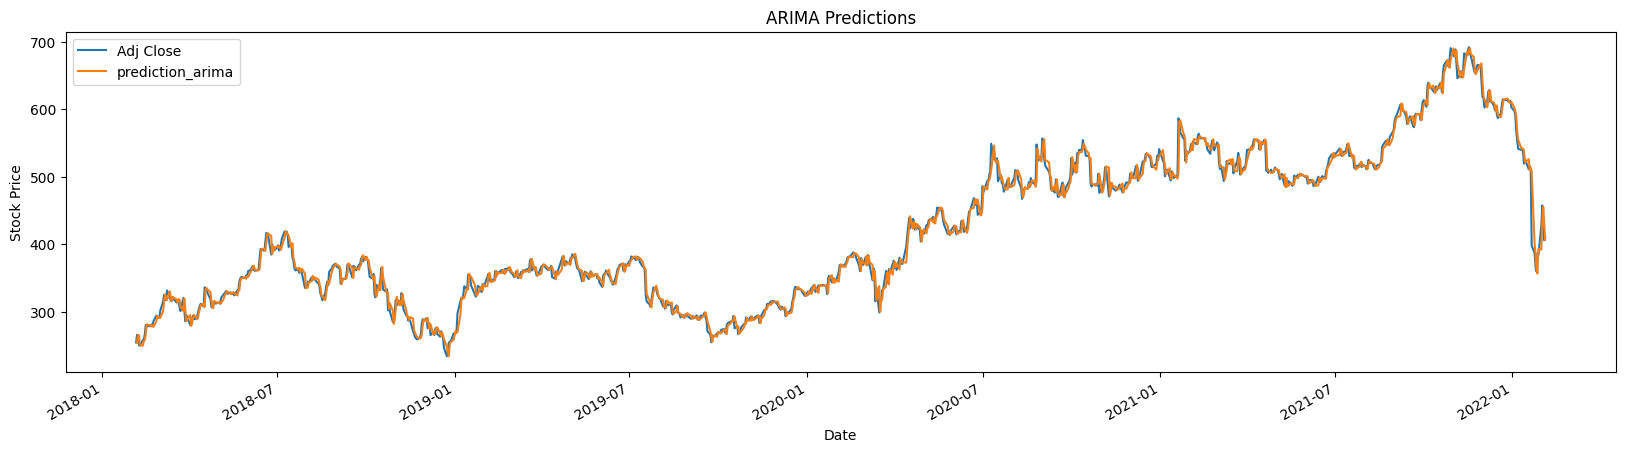

In [20]:
# Generate ARIMA predictions using the fitted model and specify the start and end indices
df['prediction_arima'] = result.predict(start=1, end=1008)

# Plot the 'Adj Close' values and ARIMA predictions from the DataFrame
df[["Adj Close", "prediction_arima"]].plot(figsize=(20, 5))

# Add x-axis label
plt.xlabel('Date')

# Add y-axis label
plt.ylabel('Stock Price')

# Add title to the plot
plt.title('ARIMA Predictions')

# Display the plot
plt.show()

In [21]:
# Generate a 30-day forecast using the fitted ARIMA model, specifying a confidence level of 95%
fc = result.forecast(90, alpha=0.05)

# Iterate over each forecasted value and print the rounded value
for i in fc:
    print(round(i, 0))

409.0
400.0
393.0
392.0
396.0
398.0
398.0
400.0
406.0
411.0
412.0
407.0
404.0
403.0
402.0
398.0
394.0
395.0
399.0
403.0
404.0
405.0
407.0
409.0
408.0
404.0
400.0
399.0
399.0
399.0
397.0
399.0
402.0
406.0
406.0
406.0
405.0
406.0
404.0
401.0
398.0
398.0
399.0
401.0
401.0
402.0
404.0
406.0
406.0
404.0
403.0
403.0
402.0
400.0
399.0
399.0
401.0
403.0
403.0
403.0
404.0
405.0
404.0
403.0
401.0
401.0
401.0
401.0
401.0
401.0
403.0
404.0
404.0
404.0
404.0
403.0
403.0
402.0
401.0
401.0
401.0
402.0
402.0
402.0
403.0
404.0
404.0
403.0
403.0
402.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: >

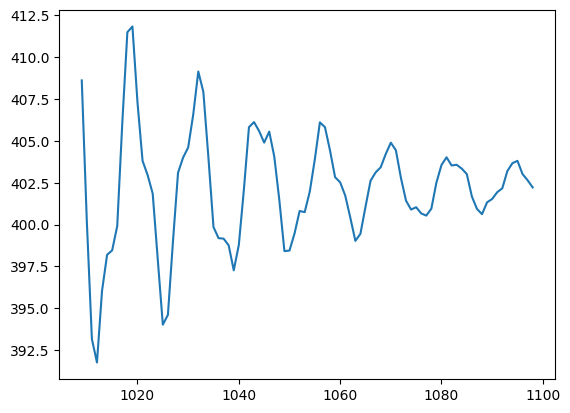

In [22]:
fc.plot()

In [23]:
#Thus, it is noted that the stock prices of the next 30 days has very small variability
# ranging between 395 and 411.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


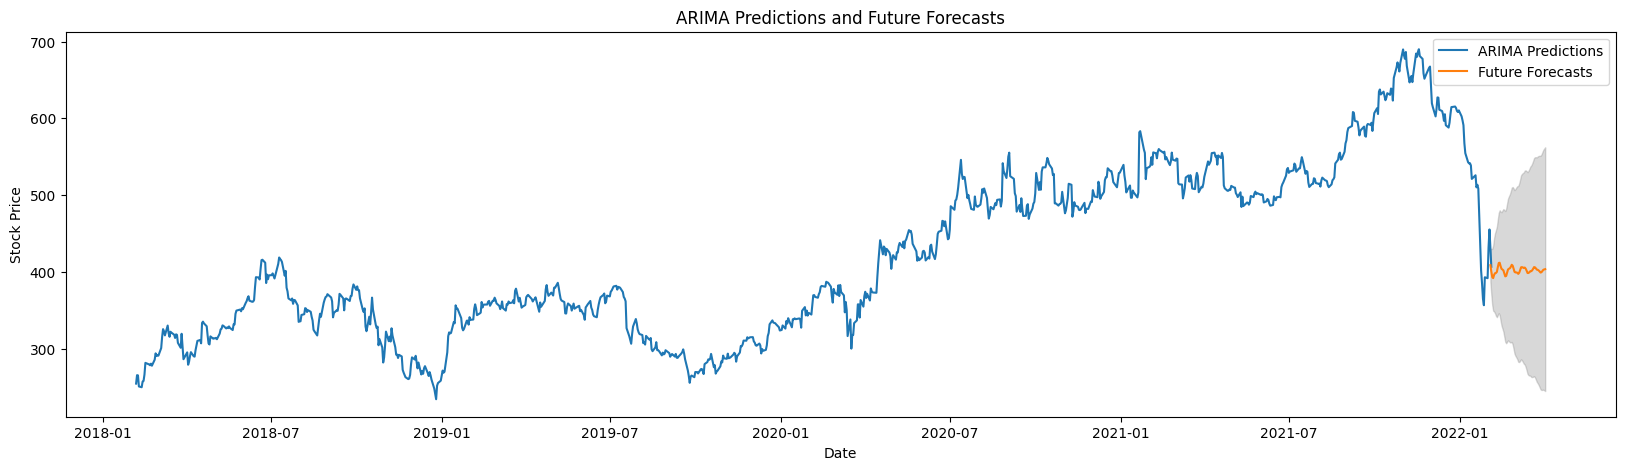

In [24]:
# Generate future forecasts
forecast = result.get_forecast(steps=60)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_confidence = forecast.conf_int()

# Create a date range for the future forecasts
start_date = '2022-02-03'  # Replace with the desired start date
end_date = pd.date_range(start=start_date, periods=len(forecast_values), freq='D')

# Plot the ARIMA predictions and future forecasts
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['prediction_arima'], label='ARIMA Predictions')
plt.plot(end_date, forecast_values, label='Future Forecasts')
plt.fill_between(end_date, forecast_confidence.iloc[:, 0], forecast_confidence.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA Predictions and Future Forecasts')
plt.legend()
plt.show()


###Observation As we saw earlier, an ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured decreasing trend in the series.
